<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/PINN_ALFASIM_1D(com_colebrook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax

In [ ]:
def colebrook_white(Re, epsilon, Dh, tol=1e-6, max_iter=1000):
    #Chute inicial para f
    f = 0.02
    for i in range(max_iter):
        #Valor da equação de Colebrook-White
        f_new = 1 / (-4 * jnp.log10(epsilon/(3.7 * Dh) + 1.255/(Re * jnp.sqrt(f)))) ** 2
        #convergência
        if jnp.abs(f - f_new) < tol:
            break
        f = f_new

    return f

def fator_f(reynolds, rugosidade, diametro, regiao):
    f_wk0 = colebrook_white(reynolds, rugosidade, diametro)
    #Define F(Re_k, Re_w)
    if regiao == "perfurado":
        F = 1 - 0.0153 * Re_w**0.3978
    elif regiao == "openhole":
        F = 1 - 29.03 *1**0.8003 #divisão (Re_w/Re_w)**0.8003 = 1**0.8003
    else:
        raise ValueError("Região inválida. Use 'perfurado' ou 'openhole'.")

    return f_wk0 * F

def tensao_w(f_wk, rho_k, v_k):
    return 0.5 * f_wk * rho_k * jnp.abs(v_k) * v_k

In [ ]:
N_b = 100
N_r = 12000

xmin, xmax = 0., 10. #Comprimento do duto em m
tmin, tmax = 0., 20.
diametro = 0.12
regiao = "perfurado"
rugosidade = 0.00016 #rugosidade equivalente em m, duto de aço galvanizado
vl = 1.
vg = 1.
densagua= 1000.
densoleo = 850.
viscdina = 1.0016 #viscosidade dinamica agua a 20°C, mPa*s
Re_w = vl*diametro/viscdina
f_wk = fator_f(Re_w, rugosidade, diametro, regiao)
tau_wk = tensao_w(f_wk, densagua, vl)

lb = jnp.array([xmin, tmin])
ub = jnp.array([xmax, tmax])


b01, bk1, bk2, bk3, bk4, r0k, r1k, r2k = jax.random.split(jax.random.PRNGKey(0),8)

#Condição inicial
#Funções para definir condições iniciais e de contorno
def c_contorno(t, x):
  return jnp.where(x == xmin, jnp.ones_like(x), jnp.zeros_like(x))

def c_inicial(x):
  return jnp.zeros_like(x)

def p_contorno(t, x):
  return jnp.ones_like(x)
# Geração dos pontos de condição inicial
x0 = jax.random.uniform(jax.random.PRNGKey(0), (N_b, 1), minval=lb[0], maxval=ub[0])
t0 = jnp.zeros((N_b, 1))
uw0 = c_inicial(x0)*0.6 #60% de água
uo0 = jnp.zeros_like(x0)*0.4
#v_y2 = jax.random.uniform(jax.random.PRNGKey(10), (N_b, 1), minval=vmin, maxval=vmax)
espaco0 = jnp.concatenate([x0, t0], axis=1)

# Geração dos pontos de contorno x=0
tbx1 = jax.random.uniform(jax.random.PRNGKey(1), (N_b, 1), minval=lb[1], maxval=ub[1])
xbx1 = jnp.zeros((N_b, 1))
#para permanente
'''
uw = c_contorno(tbx1, xbx1)*1.
uo = c_contorno(tbx1, xbx1)*0.
'''
#para transiente
uw = c_contorno(tbx1, xbx1)*0.6
uo = jnp.ones_like(tbx1) - uw
#pressao = c_contorno(tbx1, xbx1
pressaox1 = c_contorno(tbx1, xbx1)*1

termofonte = 0.05

espacobx1 = jnp.concatenate([xbx1, tbx1], axis=1)

# Geração dos pontos de contorno x=1
tbx2 = jax.random.uniform(jax.random.PRNGKey(2), (N_b, 1), minval=lb[1], maxval=ub[1])
xbx2 = jnp.ones((N_b, 1)) * ub[0]
espacobx2 = jnp.concatenate([xbx2, tbx2], axis=1)
pressaox2 = c_contorno(tbx1, xbx1)*0.9

#collocation points
t_c = jax.random.uniform(r0k,minval=tmin,maxval=tmax,shape=(N_r,1))
x_c = jax.random.uniform(r2k,minval=xmin,maxval=xmax,shape=(N_r,1))
#v_val = jax.random.uniform(jax.random.PRNGKey(10), (N_r, 1), minval=vmin, maxval=vmax)
colloc = jnp.concatenate([x_c, t_c],axis=1)

In [ ]:
def PDE_loss(x, t, alphal, alphag, pressao):
  alphal_x = lambda x, t: jax.grad(lambda x, t: jnp.sum(alphal(x, t)), 0)(x, t)

  alphal_t = lambda x, t: jax.grad(lambda x, t: jnp.sum(alphal(x, t)), 1)(x, t)

  alphag_x = lambda x, t: jax.grad(lambda x, t: jnp.sum(alphag(x, t)), 0)(x, t)

  alphag_t = lambda x, t: jax.grad(lambda x, t: jnp.sum(alphag(x, t)), 1)(x, t)

  pressao_x = lambda x, t: jax.grad(lambda x, t: jnp.sum(pressao(x, t)), 0)(x,t)

  return (1.0*alphal_x(x, t) + termofonte),  (1.0*alphag_x(x, t) - termofonte), (1.0*1000*alphal_x(x, t) + alphal(x, t)*pressao_x(x, t) + termofonte), (1.0*850*alphag_x(x, t) + alphag(x, t)*pressao_x(x, t) - termofonte)
  Fd = (2*0.005*(1+75*alphal(x, t))*jnp.sqrt(1-alphal(x, t))*850*jnp.absolute(vg - vl)*(vg-vl))/0.12
  ptsl = 2*0.0010*densagua*vl*vl/0.12
  #return (alphal_t(x,t) + vl*alphal_x(x, t)), (alphag_t(x, t) + vg*densoleo*alphag_x(x, t)), (vl*alphal_t(x, t) + (vl**2)*alphal_x(x, t) + alphal(x, t)*pressao_x(x, t)/densagua + Fd/densagua), (vg*alphag_t(x, t) + (vg**2)*alphag_x(x, t) + alphag(x, t)*pressao_x(x, t)/densoleo - Fd/densoleo)

  #return (alphal_t(x, t) + 1.0*alphal_x(x, t) + termofonte), (alphag_t(x, t) + 1.0*alphag_x(x, t) - termofonte)

def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(9),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params, x, t):
  # Concatenar t, x e y para formar o input da rede
  X = jnp.concatenate([x, t], axis=1)
  *hidden, last = params
  for layer in hidden:
    X = jax.nn.tanh(X @ layer['W'] + layer['B'])
  return X @ last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def loss_fun(params,colloc,espaco0, espacobx1, espacobx2, uw0, uo0, uw, uo, px1, px2):
  x_c, t_c= colloc[:,[0]], colloc[:,[1]]
  alphal = lambda x, t: fwd(params,x, t)[:,[0]]

  alphag = lambda x, t: fwd(params,x, t)[:,[1]]

  pressao = lambda x, t: fwd(params, x, t)[:,[2]]

  #alpha = lambda x,t: jnp.ones_like(fwd(params, x))

  erro_cl, erro_cg, erro_ml, erro_mg = PDE_loss(x_c, t_c, alphal, alphag, pressao)

  loss =jnp.mean(erro_cl**2) + jnp.mean(erro_cg**2) + jnp.mean(erro_ml**2) + jnp.mean(erro_mg**2)

  #print(cfunc(x_c, y_c, t_c))
  #print(alphal(espaco0[:,[0]], espaco0[:,[1]]))
  loss += MSE(alphal(espaco0[:,[0]], espaco0[:,[1]]), uw0) + MSE(alphag(espaco0[:,[0]], espaco0[:,[1]]), uo0)
  loss += MSE(alphal(espacobx1[:,[0]], espacobx1[:,[1]]), uw) + MSE(alphag(espacobx1[:,[0]], espacobx1[:,[1]]), uo)
  loss += MSE(pressao(espacobx1[:,[0]], espacobx1[:,[1]]), px1) + MSE(pressao(espacobx2[:,[0]], espacobx2[:,[2]]), px2)

  return  loss

@jax.jit
def update(opt_state,params, colloc,espaco0, espacobx1, espacobx2, uw0, uo0, uw, uo, px1, px2):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,espaco0, espacobx1, espacobx2, uw0, uo0, uw, uo, px1, px2)

  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state,params

In [ ]:
def PDE_loss(x, alphal, alphag, pressao):
  alphal_x = lambda x: jax.grad(lambda x: jnp.sum(alphal(x)), 0)(x)

  alphag_x = lambda x: jax.grad(lambda x: jnp.sum(alphag(x)), 0)(x)

  pressao_x = lambda x: jax.grad(lambda x: jnp.sum(pressao(x)), 0)(x)

  cfi = 0.005*(1+75*alphal(x))

  Fd = (2*cfi*jnp.sqrt(1-alphal(x))*850*jnp.absolute(vg - vl)*(vg-vl))/0.12
  Fd = 0 #aproximei para zero pq a matriz de Fd ou dava nan ou 0
  ptsl = 2*0.0010*densagua*vl*vl/0.12

  #retorno sem Fd e ptsl
  #return (1.0*alphal_x(x) + termofonte),  (1.0*alphag_x(x) - termofonte), (1.0*1000*alphal_x(x) + alphal(x)*pressao_x(x) + termofonte), (1.0*850*alphag_x(x) + alphag(x)*pressao_x(x) - termofonte)
  #retorno para o duto horizontal
  return (vl*densagua*alphal_x(x) + termofonte), (vg*densoleo*alphag_x(x) - termofonte), ((vl**2)*alphal_x(x) + alphal(x)*pressao_x(x)/densagua + Fd/densagua + tau_wk/densagua + termofonte), ((vg**2)*alphag_x(x) + alphag(x)*pressao_x(x)/densoleo - Fd/densoleo - termofonte)
  #retorno para o duto vertical
  #return (vl*densagua*alphal_x(x)), (vg*densoleo*alphag_x(x)), ((vl**2)*alphal_x(x) + alphal(x)*pressao_x(x)/densagua + Fd/densagua + alphal(x)*9.81), (1.0*alphag_x(x) + alphag(x)*pressao_x(x)/densoleo - Fd/densoleo + alphag(x)*9.81)

def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(9),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params, x):
  # Concatenar t, x e y para formar o input da rede
  X = x
  *hidden, last = params
  for layer in hidden:
    X = jax.nn.tanh(X @ layer['W'] + layer['B'])
  return X @ last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def loss_fun(params,colloc,espaco0, espacobx1, espacobx2, uw0, uo0, uw, uo, px1, px2):
  x_c= colloc[:,[0]]
  alphal = lambda x: fwd(params,x)[:,[0]]

  alphag = lambda x: fwd(params,x)[:,[1]]

  pressao = lambda x: fwd(params,x)[:,[2]]

  #alpha = lambda x,t: jnp.ones_like(fwd(params, x))

  erro_cl, erro_cg, erro_ml, erro_mg = PDE_loss(x_c, alphal, alphag, pressao)

  loss =jnp.mean(erro_cl**2) + jnp.mean(erro_cg**2) + jnp.mean(erro_ml**2) + jnp.mean(erro_mg**2)

  loss += MSE(alphal(espacobx1[:,[0]]), uw) + MSE(alphag(espacobx1[:,[0]]), uo)
  loss += MSE((alphag(x_c) + alphal(x_c)), jnp.ones_like(x_c))
  loss += MSE(pressao(espacobx1[:,[0]]), px1) + MSE(pressao(espacobx2[:,[0]]), px2)

  return  loss

@jax.jit
def update(opt_state,params, colloc,espaco0, espacobx1, espacobx2, uw0, uo0, uw, uo, px1, px2):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,espaco0, espacobx1, espacobx2, uw0, uo0, uw, uo, px1, px2)

  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state,params

In [ ]:
params = init_params([2]+[64]*4+[3])

lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [ ]:
params = init_params([1]+[64]*4+[3])

lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [ ]:
%%time
erro = []
epochs = 1500
for i in range(epochs):
    opt_state, params = update(opt_state, params, colloc, espaco0, espacobx1, espacobx2, uw0, uo0, uw, uo, pressaox1, pressaox2)

    # Calcular a perda e salvar no histórico
    loss_value = loss_fun(params, colloc, espaco0, espacobx1, espacobx2, uw0, uo0, uw, uo, pressaox1, pressaox2)
    erro.append(loss_value)

    # Exibir informações a cada 100 épocas
    if i % 100 == 0:
        print(f'Epoch={i}\tloss={loss_value:.3e}')

Epoch=0	loss=7.425e+00
Epoch=100	loss=2.744e-01
Epoch=200	loss=2.584e-01
Epoch=300	loss=2.376e-01
Epoch=400	loss=1.812e-01
Epoch=500	loss=9.850e-02
Epoch=600	loss=4.544e-02
Epoch=700	loss=3.604e-02
Epoch=800	loss=3.090e-02
Epoch=900	loss=8.447e-02
Epoch=1000	loss=2.498e-02
Epoch=1100	loss=2.301e-02
Epoch=1200	loss=2.139e-02
Epoch=1300	loss=2.000e-02
Epoch=1400	loss=1.885e-02
CPU times: user 33min 54s, sys: 5min 47s, total: 39min 42s
Wall time: 24min 40s


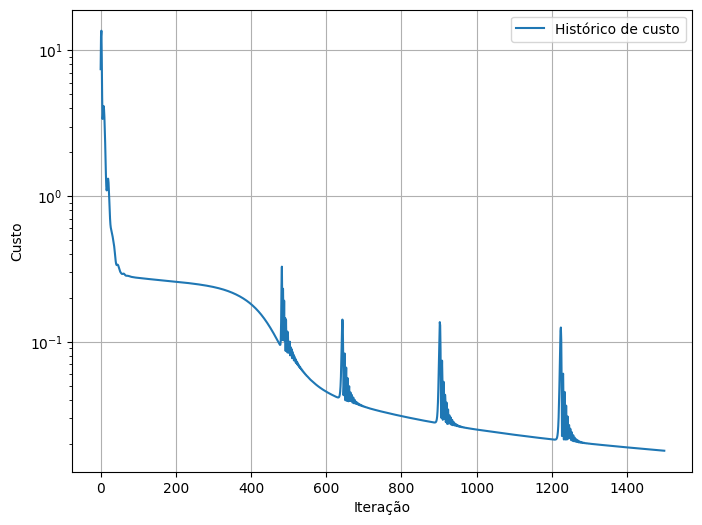

In [ ]:
plt.figure(figsize=(8, 6))
plt.semilogy(range(len(erro)), erro, label='Histórico de custo')
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.legend()
plt.grid(True)
plt.show()

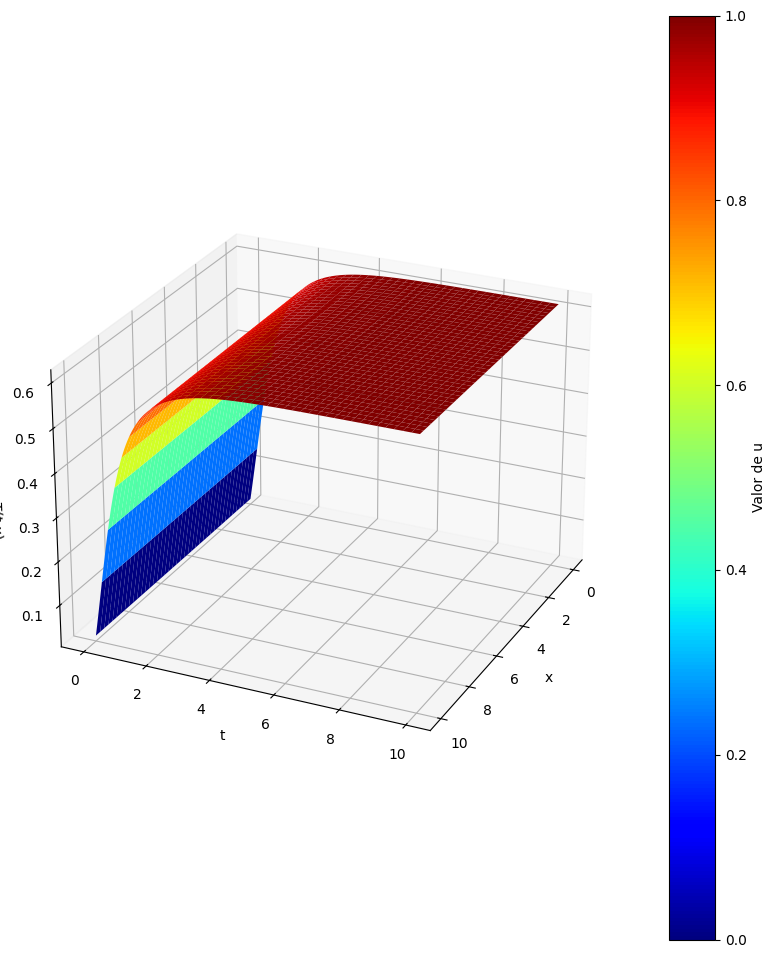

In [ ]:
N = 200
xspace = np.linspace(xmin, 10, N + 1)
tspace = np.linspace(tmin, 10, N + 1)
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T

results = fwd(params, Xgrid[:,[0]], Xgrid[:,[1]])
ul_np = results[:,[0]].reshape(N+1, N+1)

fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, ul_np, cmap='jet');
ax.view_init(25,25)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('T(t,x)')
#ax.set_title('Solução da equação de Condutividade térmica 1D')
plt.colorbar(mpl.cm.ScalarMappable(cmap='jet'), ax=ax, label='Valor de u')
plt.show()

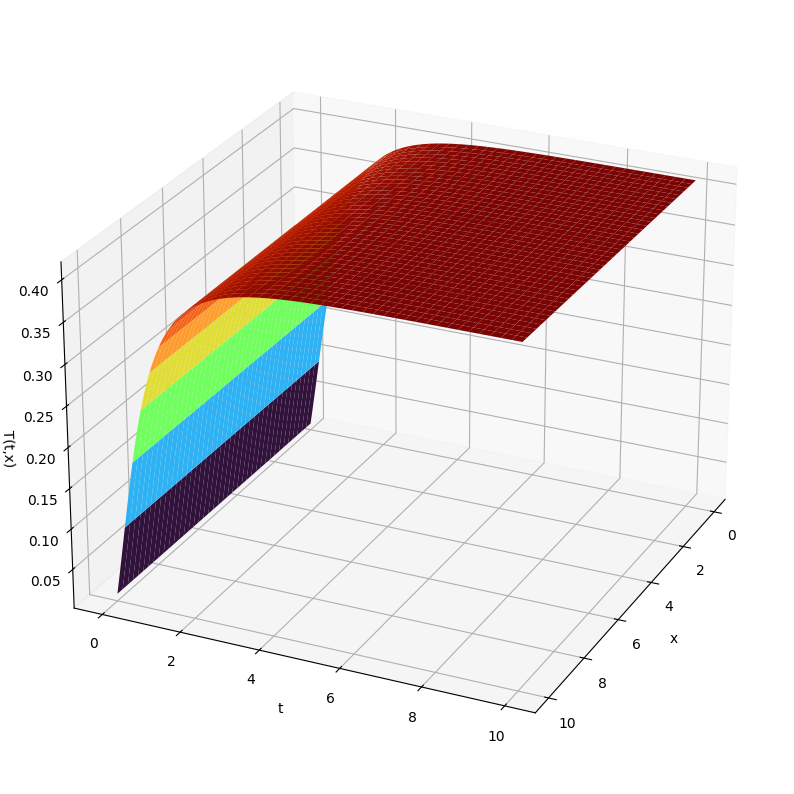

In [ ]:
ug_np = results[:,[1]].reshape(N+1, N+1)

fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, T, ug_np, cmap='turbo');
ax.view_init(25,25)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('T(t,x)')
#ax.set_title('Solução da equação de Condutividade térmica 1D');
#plt.colorbar(mpl.cm.ScalarMappable(cmap='jet'), ax=ax, label='Valor de u')
plt.show()

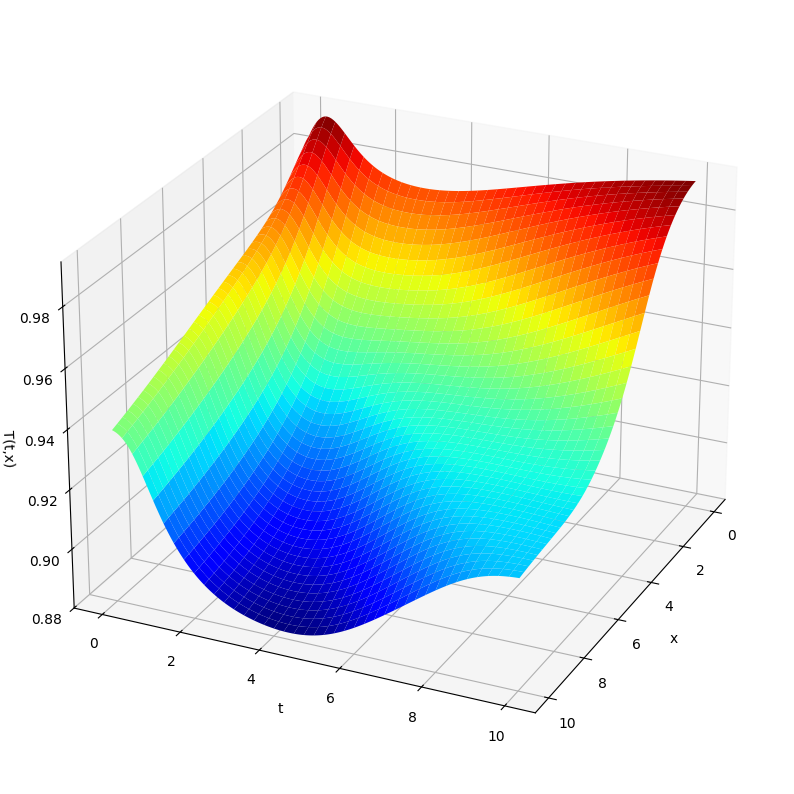

In [ ]:
pressao_np = results[:,[2]].reshape(N+1, N+1)

fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, T, pressao_np, cmap='jet');
ax.view_init(25,25)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('T(t,x)')
#ax.set_title('Solução da equação de Condutividade térmica 1D');
#plt.colorbar(mpl.cm.ScalarMappable(cmap='jet'), ax=ax, label='Valor de u')
plt.show()

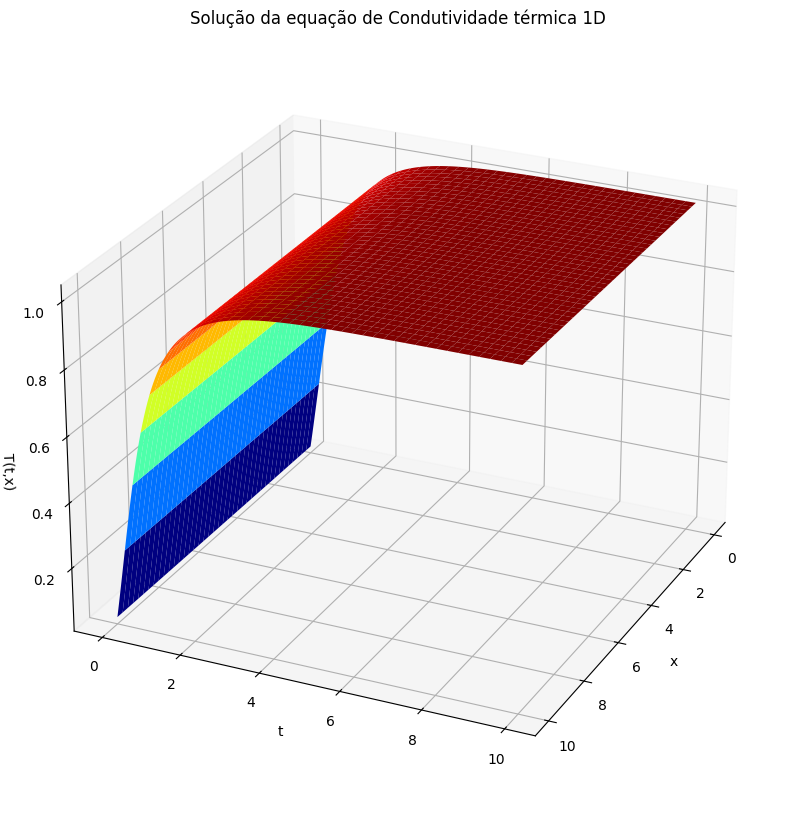

In [ ]:
ut = ug_np + ul_np
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, (ug_np+ul_np), cmap='jet');
ax.view_init(25,25)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('T(t,x)')
ax.set_title('Solução da equação de Condutividade térmica 1D');
plt.show()

In [ ]:
x_plot = jnp.linspace(xmin, xmax, 1000).reshape(-1, 1)  # Criar valores de x para o plot
  # Criar array com tempo fixo para todos os x
alphal_vals = fwd(params, x_plot)[:, [0]]  # Fração mássica de líquido
alphag_vals = fwd(params, x_plot)[:, [1]]  # Fração mássica de gás
pressao_vals = fwd(params, x_plot)[:, [2]]  # Pressão

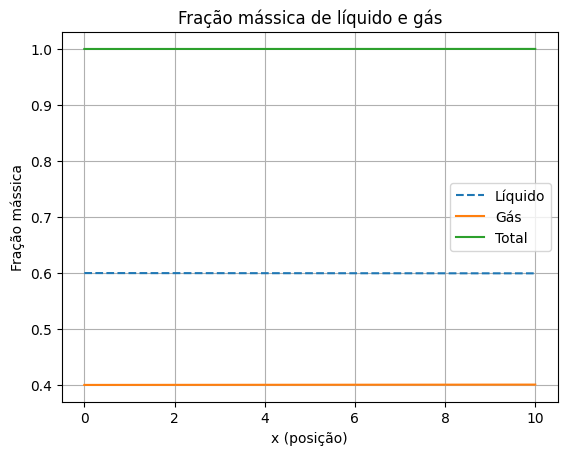

In [ ]:
alpha = alphag_vals + alphal_vals
# Plotar a fração mássica de líquido
plt.plot(x_plot, alphal_vals, label=f'Líquido',  linestyle='--',)

# Plotar a fração mássica de gás
plt.plot(x_plot,alphag_vals,label=f'Gás',)

plt.plot(x_plot, alpha, label=f'Total')

# Configurações do gráfico
plt.xlabel("x (posição)")
plt.ylabel("Fração mássica")
plt.title("Fração mássica de líquido e gás")
plt.legend()
plt.grid(True)
plt.show()

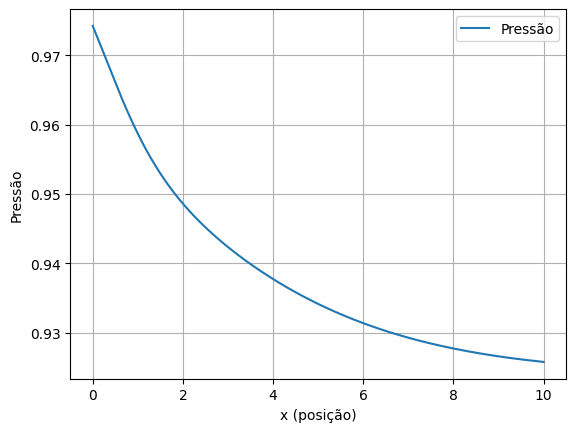

In [ ]:
plt.plot(x_plot, pressao_vals, label=f'Pressão')

# Configurações do gráfico
plt.xlabel("x (posição)")
plt.ylabel("Pressão")
plt.title("")
plt.legend()
plt.grid(True)
plt.show( )